In [21]:
import graph_tool.all as gt
import numpy as np
import time
import sys

In [2]:
def WD(graph): #Algorithm WD that computes both the W and the D matrix from a known graph. 
    W = np.zeros((graph.num_vertices(),graph.num_vertices())) #Initialize W Matrix
    D = np.zeros((graph.num_vertices(),graph.num_vertices())) #Initialize D Matrix
    #print(W)
    #print(D)

    g2 = gt.Graph(graph) #Copy the graph to perform other operations.

    ordered_pair = g2.new_edge_property("vector<int>")
    g2.edge_properties["weight_pair"] = ordered_pair

    for edge in graph.edges():
        g2.ep.weight_pair[edge] = [graph.ep.weight[edge], graph.vp.cap[edge.source()]*(-1)]
    
    for i in range(graph.num_vertices()):
        for j in range(graph.num_vertices()):
            if (i!=j): #Exclude the same node path calculation.
                #Calculate the total weight of the path we just got.
                path = gt.shortest_path(g2, i, j)
                weightSum = [0,0] #Ordered pair weightSum [x,y] that will be: [w(e), -d(u)]
                for item in path[1]:
                    #print(item)
                    weightSum = [weightSum[0] + g2.ep.weight_pair[item][0], weightSum[1] + g2.ep.weight_pair[item][1]]

                #print(weightSum)
                #Coge weightSum y haz las respectivas operaciones con (x,y); W(u,v) y D(u,v)              

                W[i][j] = weightSum[0] #W(u,v) = x 
                #print(W[i][j])

                D[i][j] = g2.vp.cap[j] - weightSum[1] #D(u,v) = d(v) -y
                #print(D[i][j])
            else:
                D[i][j] = graph.vp.cap[graph.vertex(i)]


    #print("W Matrix: ") #Erased because of Profiler.
    #print(W)
    #print("D Matrix: ")
    #print(D)
    return [W,D]

In [3]:
def cp(graph, display=False):
    g0 = gt.Graph(graph)
    
    removedEdges = []

    for edge in g0.edges():
        if (g0.ep.weight[edge]!=0):
            removedEdges.append([edge.source(),edge.target()])

    delta = g0.new_vertex_property("int") #Property delta(node) in the reference paper.

    for i in range(len(list(g0.vertices()))):
        delta[i] = 0

    g0.vertex_properties["delta"] = delta

    for i in range(len(removedEdges)):
        g0.remove_edge(g0.edge(removedEdges[i][0], removedEdges[i][1]))

    if(display):
        gt.graph_draw(g0, vertex_text=g0.vp.cap, edge_text=g0.ep.weight)
        
    #Topological Sort
    
    sortedGraph = gt.Graph(g0)
    tree = gt.min_spanning_tree(g0)
    g0.set_edge_filter(tree)
    sort = gt.topological_sort(g0)
    if (display):
        print(sort)
    
    #Calculate Clock Period of the Graph:
    for node in sort:

        if (g0.vertex(node).in_degree()==0): #If the node doesn't have incoming edges. 
             g0.vp.delta[node] = g0.vp.cap[node]
        else:
            maxDelta = 0
            for edge in g0.vertex(node).in_edges():
                if (g0.vp.delta[g0.vertex(edge.source())] > maxDelta):
                    maxDelta = g0.vp.delta[g0.vertex(edge.source())]

            g0.vp.delta[node] = g0.vp.cap[node] + maxDelta

    clockPeriod = 0
    for node in sort:
        if (g0.vp.delta[node] > clockPeriod): #Update clock period 
            clockPeriod = g0.vp.delta[node]

    if(display):
        print("Clock Period of the graph is: " + str(clockPeriod))
    
    return g0, clockPeriod

In [32]:
def FEAS(g, c): #Input: Graph g, clock period 'c' from D(u,v); Output: Clock period and optimal retiming found.  
                #For visualization purposes, the majority of graph drawings, sorts and other data outputs no more important 
                #than the clock period and the retiming is omitted to show a clean answer.
                #The notebook: 'RetimingProject_10670388_FEAS' shows the solution with more steps. 
    retimings = []
    for i in range(g.num_vertices()):
        retimings.append(0)
    #print(retimings)

    for i in range(g.num_vertices()):
    
        #We proceed to calculate the new retiming weights.
        gFinal = gt.Graph(g)
        #print(gFinal)

        for edge in gFinal.edges():
            source = int(str(edge.source())) #Get source node from edge.
            target = int(str(edge.target())) #Get target node from edge.
            gFinal.ep.weight[edge] = gFinal.ep.weight[edge] + retimings[target] - retimings[source] 

        #Compute Clock Period Algorithm (Algorithm CP)
            
        solution = cp(gFinal)[0]
      
        for vertex in solution.vertices():
            if (solution.vp.delta[vertex]>c):
                retimings[int(vertex)] = retimings[int(vertex)] + 1 #Get new Retimings.

        #print(retimings)

    #Perform algorithm CP Again. 
    
    clockPeriod = cp(solution)[1]
    
    #print("FEAS Algorithm finished with c: "+str(c))
    #print("Clock Period of the graph is: " + str(clockPeriod))

    
    #if (clockPeriod > c):
     #   print("No feasible retiming exists.")
    #else:
     #   print("Retiming: %s is the desired retiming." % (retimings))
        
    return clockPeriod, retimings

In [41]:
def OPT1(g):
    tupleWD = WD(g) #Perform W and D matrix computation for the algorithm #Step 1 from OPT1.
    W = tupleWD[0]
    D = tupleWD[1]
    copyD = np.copy(D) #This is the array we will sort. 
    copyD = np.unique(copyD) #Step 2 from OPT1.
    #r(u) - r(v) <= w(e)
    optimalRetiming = []
    
    minimumClockPeriod = sys.maxsize
    for i in range(len(copyD)):     #Gets calculated with sorted D(u,v)

        c = copyD[i]
        
        g5 = gt.Graph(g) #Create a copy of the graph in order to perform other operations. 

        nodesSize = g5.num_vertices() #Get the number of the nodes.

        g5.add_vertex() #Add new artificial node to perform the shortest-path. 

        for i in range(nodesSize):
            e = g5.add_edge(nodesSize, i) #We add the nodesSize number-index as the new node for the Bellman Ford algorithm.
            g5.ep.weight[e] = 0

        for edge in g5.edges(): #Visualization purposes. #Theorem 7.1 in the Reference Paper.
            if (edge.source()!=nodesSize and edge.target()!=nodesSize):

                #print("r(u): %s, r(v): %s with edge: %s" % (edge.source(), edge.target(), edge_weight[edge]))

                source = int(str(edge.source()))
                target = int(str(edge.target()))

        for node1 in range(g5.num_vertices()): #Theorem 7.2 in the Reference Paper.
            for node2 in range(g5.num_vertices()):

                if (node1!=node2 and node1!= nodesSize and node2!= nodesSize):
                    if (D[node1][node2] > c):
                        if(not( ( (D[node1][node2] - g5.vp.cap[node1]) > c) or ( (D[node1][node2] - g5.vp.cap[node2]) > c) ) ):
                            e = g5.add_edge(node1,node2)
                            g5.ep.weight[e] = W[node1][node2] - 1

        #(Inequalities)
        minPathSums = [] #Initialize the array of Minimum Path Sums
        minPath = []

        for i in range(nodesSize):
            minPathSums.append(sys.maxsize)

        isPossible = True #Flag in order to know if there is not any violation in the constraints. 
        for i in range(nodesSize):
            if (isPossible):
                try:
                    path = gt.shortest_path(g5, nodesSize, i, weights=g5.ep.weight, negative_weights=True) 
                    #print(path)
                    pathSum = 0 

                    for item in path[1]:        
                        pathSum = pathSum + g5.ep.weight[item] 

                    if (pathSum < minPathSums[i]):
                            minPathSums[i] = pathSum
                            minPath = path
                            
                except ValueError: 
                    isPossible = False
                    #print("Negative Loops Found. Skipping Solution...")

        if (isPossible):
            #Now that we found a solution to the Linear Inequalities, we proceed to calculate the new retiming weights.

            #for i in range(len(minPathSums)):
                #print(minPathSums[i])
                        
            gFinal = gt.Graph(g)
                #print(gFinal)

            for edge in gFinal.edges():
                source = int(str(edge.source()))
                target = int(str(edge.target()))
                gFinal.ep.weight[edge] = gFinal.ep.weight[edge] - minPathSums[target] + minPathSums[source] 
                #The reason the subtraction is swapped here is because the edges for the Bellman-Ford algorithm 
                #were created in the inverse order for simplification purposes.
                #By replacing the target and the source operation, we get the original operation with values that satisfy
                #the Theorem 7. 
                #print("Edge: %s with new value: %s" % (edge, gFinal.ep.weight[edge]))

            #New Graph Gr
            #print("New Graph Gr: ")
            #gt.graph_draw(gFinal, vertex_text=gFinal.vertex_index, edge_text=gFinal.ep.weight)
            
            clockPeriod = cp(gFinal)[1]

            #print("Clock Period of the graph is: %s with value of c as: %s" % (clockPeriod, c)) #ERASED PROFILING
            if (clockPeriod < minimumClockPeriod):
                minimumClockPeriod = clockPeriod
                clockPeriodFound = c
                optimalRetiming = minPathSums

    print("Minimum Clock Period is: %s with c: %s" % (minimumClockPeriod, clockPeriodFound))
    print("Retiming: %s" % (optimalRetiming))
    return optimalRetiming

In [42]:
def sample_k(): #Sample to generate the In and Out Degree of each node in the graph. 
    #Taken from Graph-Tool documentation: A degree sampler function which is called without arguments, and returns a 
    #tuple of ints representing the in and out-degree of a given vertex (or a single int for undirected graphs, 
    #representing the out-degree).
    inOutDegree = np.random.randint(maxNodeDegree, size=2)
    if (inOutDegree[0] == 0): #Since all the graph needs to be connected, we impose at least one edge for each node.
        inOutDegree[0] = 1
    if (inOutDegree[1] == 0): #Since all the graph needs to be connected, we impose at least one edge for each node.
        inOutDegree[1] = 1
    return inOutDegree

In [43]:
def graphGenerator(nodes_size, delayRange=None, simpleDelayArray=True, weightRange=3, seed=None):
    #The following function generates a random graph with the following inputs:
    #nodes_size: number of vertices/nodes in the graph.
    #delayRange: specifies the range from [0-delayRange] in order to create an array of propagation delay.
    #simpleDelayArray: if it's true, the propagation delay of each index will be equal to the index of the vertex.
    #seed: a certain seed can be stated in order for the results to be totally reproducible. 
    #In order to do a quick test of the graph generator, the default values for a graph generation is to create
    #a graph with simple (random) values for the weight and simple values for the propagation delay of the index.
    
    if(seed!= None): #In order to make our data reproducible, we put a certain seed. 
            
        gt.seed_rng(seed)

        np.random.seed(seed)
        
    g = gt.random_graph(nodes_size, sample_k) #Execute graph_tool random graph generator with a certain numbers of nodes and
                                              #the sample_k
    
    edge_weight = g.new_edge_property("double") #Add a property to each edge of the graph.
    g.edge_properties["weight"] = edge_weight   #Rename that property to use it in the code as: g.ep.weight
    cap = g.new_vertex_property("int")          #Add a property to each vertex of the graph.
    g.vertex_properties["cap"] = cap            #Rename that property to use it in the code as: g.vp.cap
    
    #Note: the name "cap" was used as a placeholder of "propagation delay" since it's similar to a flow problem.
    #The name is just for intuitive purposes and doesn't change the internal logic of any algorithm. 

    #The weight of an edge will be a random positive number between 0 and weightRange (default value: 3). 
        
    for edge in g.edges():
        g.ep.weight[edge] = np.random.randint(weightRange, size=1)[0] 

    if (simpleDelayArray): #If it's true, the propagation delay array d(v) will be the index of the node. e.g d(0) = 0; d(4) = 4
            
        for vertex in g.vertices(): #Simple propagation delay creation. 
            g.vp.cap[vertex] = int(vertex)
    
    else:
        delayArray = np.random.randint(delayRange, size=nodes_size)
        for i in range(nodes_size): 
            g.vp.cap[i] = delayArray[i]
    
    for c in gt.all_circuits(g): #We do this validation in order to respect constraint W2.
        #print(c) Print each cycle of the graph. 
        pathSum = 0
        for item in range(len(c)-1):
            pathSum = pathSum + g.ep.weight[g.edge(c[item],c[item+1])]
            #print(pathSum)
        #Final edge sum: (edge(initial node of the cycle,last node before initial node))
        pathSum = pathSum + g.ep.weight[g.edge(c[item+1],c[0])]
        if(pathSum == 0): #If a cycle with zero weight is found.
            print("Cycle with Zero weight detected!")
            g.ep.weight[g.edge(c[item+1],c[0])] = 1 #Add 1 to the last edge in order to make it different from 0.
                                                    #This is a simply solution in order to not violate constraint W2. 
            print("Edge: %s modificated with value 1!" % (g.edge(c[item+1],c[0])))
        #else:
            #print("Path SUM: %s" % (pathSum))
    
    gt.graph_draw(g, vertex_text=g.vertex_index, edge_text=g.ep.weight) #Graph the draw for visualization.
    return g

In [45]:
def graphCorrelator(nodes_size, seed=None): 
    #Create a Graph correlator based on the examples from Leiserson and Saxe. This generator can be seen as a specific case
    #of the previous graph generator where the host node has 0 propagation delay, "bottom" nodes have 3 propagation delay and
    #upper nodes have 7. Weights are a number in the range [0-5].
    if (nodes_size < 3):
        print("Error: a correlator must have a number of nodes equal or greater than 3.")
    elif (nodes_size == 3):
        g = gt.Graph() #Base Case
    
        edge_weight = g.new_edge_property("double") #Add a property to each edge of the graph.
        g.edge_properties["weight"] = edge_weight   #Rename that property to use it in the code as: g.ep.weight
        cap = g.new_vertex_property("int")          #Add a property to each vertex of the graph.
        g.vertex_properties["cap"] = cap            #Rename that property to use it in the code as: g.vp.cap
        
        g.add_vertex(3)
        g.vp.cap[0] = 0
        g.vp.cap[1] = 3
        g.vp.cap[2] = 7
        
        g.add_edge(0,1)
        g.add_edge(1,2)
        g.add_edge(2,0)
        
        for edge in g.edges():
            g.ep.weight[edge] = np.random.randint(3, size=1)[0] 
        
    else: #General Case
        g = gt.Graph()
    
        edge_weight = g.new_edge_property("double") #Add a property to each edge of the graph.
        g.edge_properties["weight"] = edge_weight   #Rename that property to use it in the code as: g.ep.weight
        cap = g.new_vertex_property("int")          #Add a property to each vertex of the graph.
        g.vertex_properties["cap"] = cap            #Rename that property to use it in the code as: g.vp.cap
        
        g.add_vertex(nodes_size) #Create the specific number of vertex in the graph. 
        
        if (nodes_size % 2 == 0):
            numberOf7 = (nodes_size//2)-1
        else:
            numberOf7 = (nodes_size//2)
        
        numberOf3 = (nodes_size//2)
        
        #Creation of "bottom circuit" 
        for i in range(numberOf3): #Creation of nodes with 3 as propagation delay. 
            g.add_edge(i,i+1)
        
        i = i + 1 #Increase i in order to connect the appropiate edges.
        
        #Creation of "upper circuit" 
        for j in range(i, i+numberOf7): #Creation of nodes with 7 as propagation delay.
            g.add_edge(j,j+1)
        
        #Final Edge from last vertex with 7 to Host 0:
        g.add_edge(nodes_size-1, 0)
        
        #Intermediate Edges (from vertex with propagation delay 3 to 7)
        for i in range(1, numberOf3):
                g.add_edge(i, nodes_size-i)
        
        #Propagation Delay Assignation
        for i in range(1, numberOf3+1): #We add 1 to numberOf3 in order to include the final vertex of d(v) = 3.
            g.vp.cap[i] = 3
        
        for j in range(i+1, nodes_size):
            g.vp.cap[j] = 7
        
        #Weight Assignation
        for edge in g.edges():
            g.ep.weight[edge] = np.random.randint(3, size=1)[0] 
        
    if (nodes_size >= 3):
        for c in gt.all_circuits(g): #We do this validation in order to respect constraint W2.
            pathSum = 0
            for item in range(len(c)-1):
                pathSum = pathSum + g.ep.weight[g.edge(c[item],c[item+1])]

            pathSum = pathSum + g.ep.weight[g.edge(c[item+1],c[0])]
            if(pathSum == 0): #If a cycle with zero weight is found.
                print("Cycle with Zero weight detected!")
                g.ep.weight[g.edge(c[item+1],c[0])] = 1 #Add 1 to the last edge in order to make it different from 0.
                                                        #This is a simply solution in order to not violate constraint W2. 
                print("Edge: %s modificated with value 1!" % (g.edge(c[item+1],c[0])))
                
        gt.graph_draw(g, vertex_text=g.vp.cap, edge_text=g.ep.weight) #Graph the draw for visualization.
        return g

In [38]:
def OPT2(graph): #Algorithm OPT2 from the Reference paper. Complexity of the algorithm in O(|V| |E| lg |V|) time.
    tupleWD = WD(graph) #Perform W and D matrix computation for the algorithm
    W = tupleWD[0]
    D = tupleWD[1]
    copyD = np.copy(D) #This is the array we will sort. 
    copyD = np.unique(copyD)
    minimumClockPeriod = sys.maxsize
    optimalRetiming = []
    for i in range(len(copyD)): 

        c = copyD[i]
        #print("Test with C: "+str(c))
        
        solution = FEAS(graph,c) #Execute FEAS Algorithm that will give us a tuple = [clock_period, retimings]
        
        clockPeriod = solution[0]
        retimings = solution[1]
       
        #print("Clock Period of the graph (OPT2) is: %s" % (clockPeriod))
        
        #if (clockPeriod > c):
         #   print("No feasible retiming exists.")
        #else:
         #   if(clockPeriod < minimumClockPeriod):
          #      minimumClockPeriod = clockPeriod
           #     optimalRetiming = retimings
            #    print("Retiming: %s is the desired retiming." % (retimings))
            #else:
             #   print("It doesn't improve the retiming.")
                
        if (clockPeriod <= c):
            if(clockPeriod < minimumClockPeriod):
                minimumClockPeriod = clockPeriod
                optimalRetiming = retimings
                #print("Retiming: %s is the desired retiming." % (retimings))
            #else:
                #print("It doesn't improve the retiming.")

    print("Minimum Achievable Clock Period is: %s with retiming: %s" % (minimumClockPeriod, optimalRetiming))
    return minimumClockPeriod, optimalRetiming

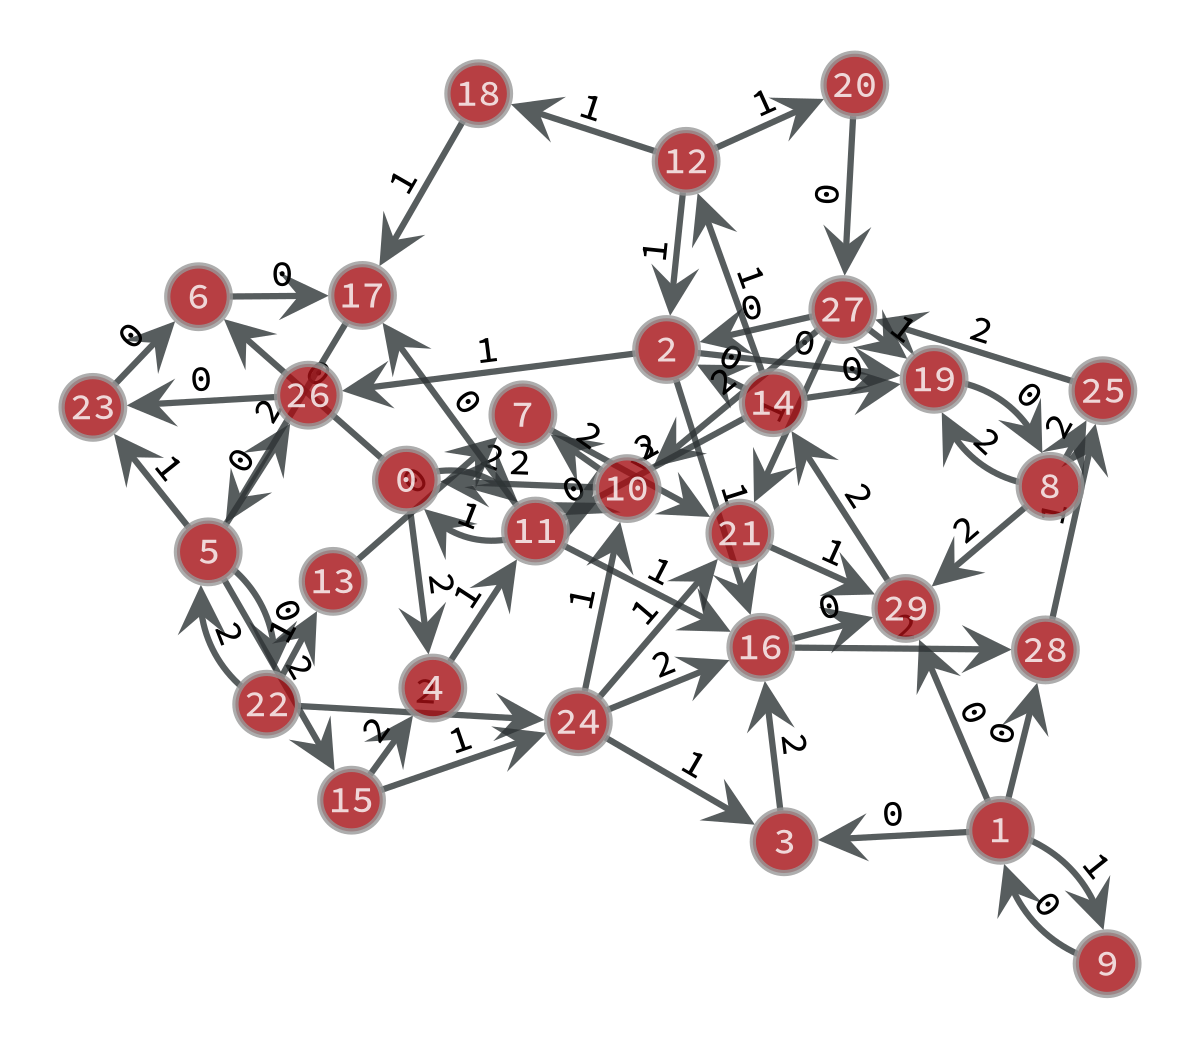

In [26]:
#Generating the Graph
maxNodeDegree = 5
gtest = graphGenerator(30)

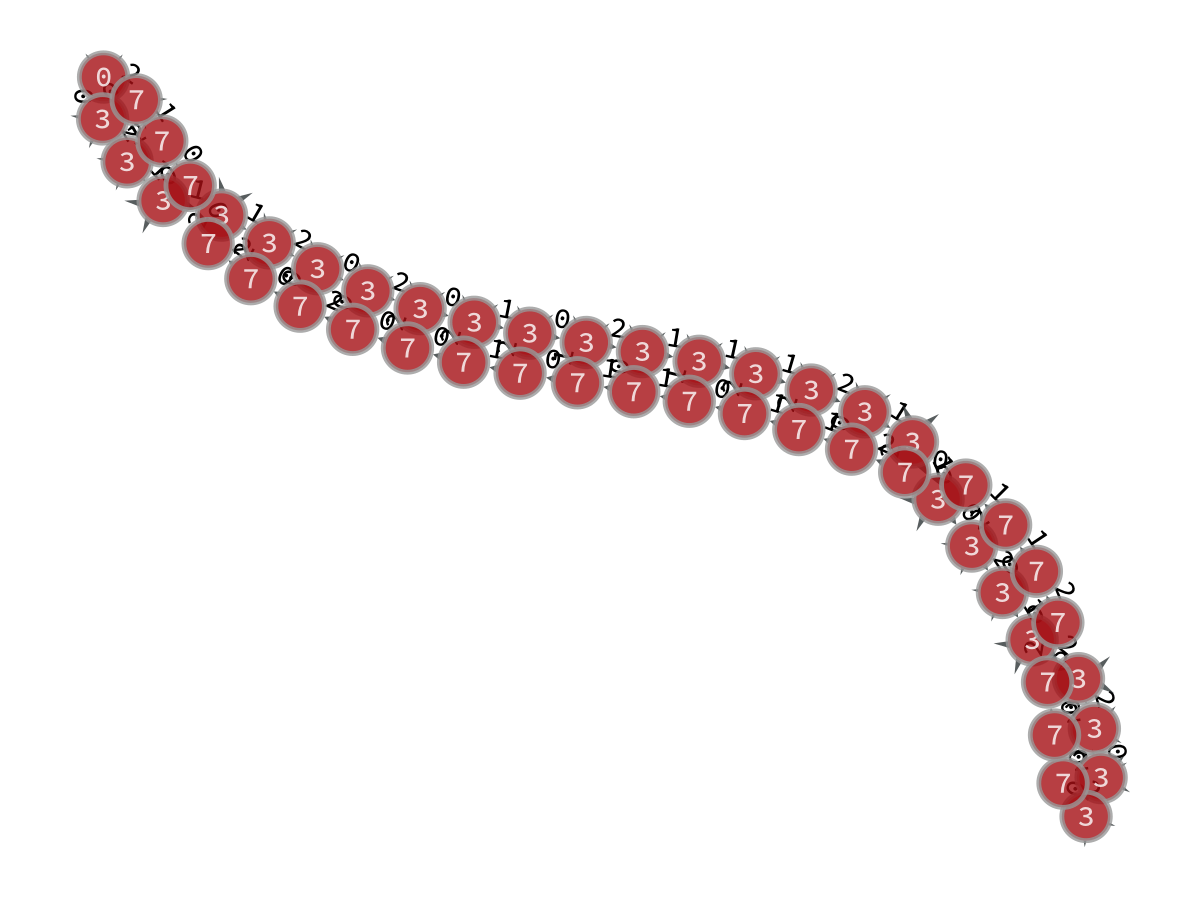

In [54]:
#Generating the Graph
gtest = graphCorrelator(50)

In [55]:
for vertex in gtest.vertices():
    print("In: %s; Out: %s" %( vertex.in_degree(), vertex.out_degree()))

In: 1; Out: 1
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 2
In: 1; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1
In: 2; Out: 1


In [56]:
start = time.process_time()
print(OPT1(gtest))
end = time.process_time()

print(end-start)

Minimum Clock Period is: 7 with c: 7.0
Retiming: [-4.0, -5.0, -3.0, -3.0, -2.0, -2.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, -2.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, -1.0, -2.0, -2.0, -2.0, -3.0, -3.0, -4.0, -5.0, -4.0, -5.0, -4.0, -5.0, -6.0, -6.0]
[-4.0, -5.0, -3.0, -3.0, -2.0, -2.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, -2.0, -1.0, -1.0, -1.0, -1.0, -2.0, -1.0, -1.0, -1.0, -2.0, -2.0, -2.0, -3.0, -3.0, -4.0, -5.0, -4.0, -5.0, -4.0, -5.0, -6.0, -6.0]
4.303534759999991


In [57]:
start = time.process_time()
print(OPT2(gtest))
end = time.process_time()

print(end-start)

Minimum Achievable Clock Period is: 7 with retiming: [4, 5, 3, 3, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 3, 3, 4, 5, 4, 5, 4, 5, 6, 6]
(7, [4, 5, 3, 3, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 3, 3, 4, 5, 4, 5, 4, 5, 6, 6])
37.265756464999996
